In [21]:
import meshio
from matplotlib.colors import LinearSegmentedColormap, ListedColormap, BoundaryNorm
import matplotlib.pyplot as plt
import numpy as np
from xrd_simulator_addons import get_ground_truth_slice
import multiprocessing as mp
import yaml
import h5py
import re
import os
import glob
from tqdm import tqdm

In [18]:


config_path = 'xrd_simulator_addons/configs/config_crystal_exp4.yaml'
with open(config_path, "r") as f:
    config = yaml.safe_load(f)
absolute_path = config["absolute_path"]
session_name = config["session_name"]
N_angles = config["experiment"]["number_of_angles"]
angles = np.linspace(0,180, N_angles)
N_translations = config["experiment"]["number_of_translations"]
integrated_path = absolute_path +'/' +session_name + '/integrated.h5'

/dtu-compute/msaca/simulated_data/diffraction/reference_183960_FeCr2O4_chro/integrated.h5
/dtu-compute/msaca/simulated_data/diffraction/reference_180326_Na(AlSi3O8)_alb/integrated.h5
/dtu-compute/msaca/simulated_data/diffraction/reference_184824_Ca5(PO4)3Cl_chl/integrated.h5


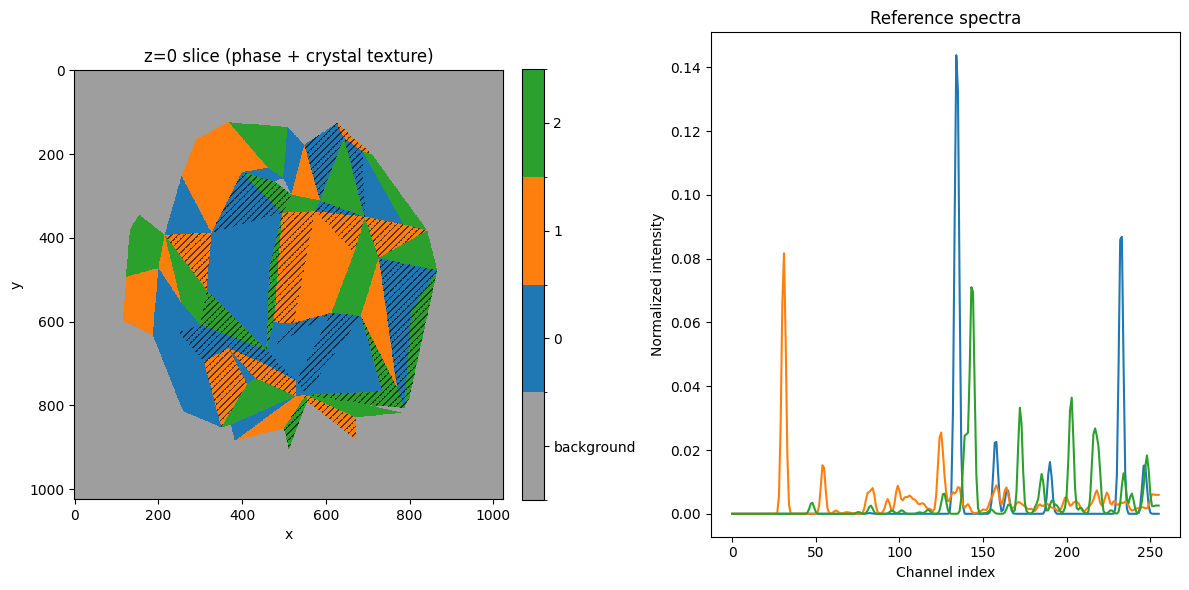

In [19]:
# --- Your data loading ---
phase_map, crystal_map = get_ground_truth_slice.get_ground_truth(config=config_path)

materials = config["materials"]["files"]
spec = []
for i in range(len(materials)):
    reference_path = absolute_path + '/reference_' + materials[i][:-4] + '/integrated.h5'
    print(reference_path)
    with h5py.File(reference_path, "r") as f:
        s = f["integrated_p"][:][0, 1, :]
        spec.append(s / s.sum())

# --- Colormaps ---
cmap = ListedColormap([
    "#9e9e9e",  # background
    "#1f77b4",  # class 0
    "#ff7f0e",  # class 1
    "#2ca02c",  # class 2
])
bounds = [-1.5, -0.5, 0.5, 1.5, 2.5]
norm = BoundaryNorm(bounds, cmap.N)

new_cmaps = []
for i, color in enumerate(cmap.colors):
    new_cmaps.append(
        LinearSegmentedColormap.from_list(f"class_{i}", ["white", color])
    )

# --- Create one figure with two panels ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# --- Left: phase + crystal texture ---
im = ax1.imshow(phase_map, origin='lower', interpolation='nearest',
                cmap=cmap, norm=norm)

ny, nx = crystal_map.shape
xx, yy = np.meshgrid(np.arange(nx), np.arange(ny))
stripe = ((xx + 1*yy) % 16) < 4
mask = (crystal_map != 0)

alpha = (mask & stripe).astype(float) * 0.65
overlay = np.zeros((ny, nx, 4), dtype=float)
overlay[..., 3] = alpha

ax1.imshow(overlay, interpolation='nearest')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title('z=0 slice (phase + crystal texture)')

cbar = plt.colorbar(im, ax=ax1, ticks=[-1, 0, 1, 2], fraction=0.046, pad=0.04)
cbar.ax.set_yticklabels(['background', '0', '1', '2'])

# --- Right: spectra ---
for i in range(len(spec)):
    ax2.plot(spec[i])
ax2.set_title("Reference spectra")
ax2.set_xlabel("Channel index")
ax2.set_ylabel("Normalized intensity")

plt.tight_layout()
plt.show()

In [23]:
def extract_index(filename):
    match = re.search(r'angle_(\d+)\.h5', filename)
    return int(match.group(1)) if match else -1

# Load and stack patterns from one file
def load_one_file(filename):
    with h5py.File(filename, 'r') as f:
        patterns = [f[key][:] for key in sorted(f.keys())]
        return np.stack(patterns)  # shape: (num_j, H, W)
    

session_name = config["session_name"]
absolute_infolder = config["absolute_path"]
inpath = os.path.join(absolute_infolder, f"{session_name}")
files = sorted(glob.glob(inpath + "/angle_*.h5"), key=extract_index)
with mp.Pool(processes=16) as pool:
    all_patterns = list(
        tqdm(pool.imap(load_one_file, files), total=len(files))
    )
diffraction_4d = np.stack(all_patterns)  # (num_angles, num_j, H, W)
num_angles, num_j, H, W = diffraction_4d.shape

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 181/181 [00:42<00:00,  4.24it/s]
